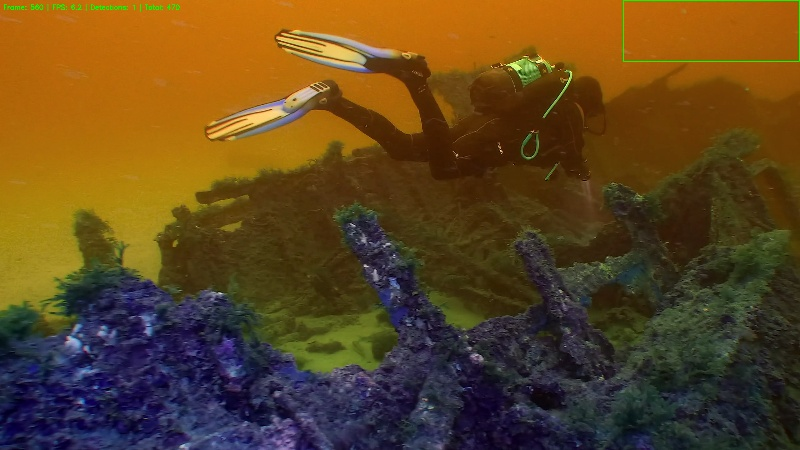

In [ ]:
# Import necessary libraries
import cv2
import supervision as sv
import numpy as np
from inference_sdk import InferenceHTTPClient
from IPython.display import Image, display, clear_output
import time
import os

# Print supervision version for reference
print(f"Using supervision version: {sv.__version__}")

# Initialize the client
CLIENT = InferenceHTTPClient(
    api_url="http://inference:9001",
    api_key=os.environ.get('ROBOFLOW_API_KEY')
)

# Define model and video path
MODEL_ID = "fish-scuba-project/2"
VIDEO_PATH = "6430501-uhd_3840_2160_25fps.mp4"

# Configure display parameters
MAX_WIDTH = 800  # Maximum width for display

# Function to resize frame for display
def resize_for_display(frame, max_width=MAX_WIDTH):
    """Resize frame while maintaining aspect ratio"""
    height, width = frame.shape[:2]
    if width > max_width:
        scale = max_width / width
        new_width = max_width
        new_height = int(height * scale)
        return cv2.resize(frame, (new_width, new_height))
    return frame

# Function to draw predictions using OpenCV
def draw_predictions(frame, prediction_data):
    """Draw bounding boxes on frame using OpenCV"""
    # Make a copy of the frame to avoid modifying the original
    annotated_frame = frame.copy()
    
    # Colors for different classes (BGR format in OpenCV)
    colors = {
        'school of fish': (0, 255, 0),    # Green
        'seafloor': (0, 165, 255),        # Orange
        'fish': (255, 0, 0),              # Blue
        'coral': (255, 255, 0),           # Cyan
        'default': (0, 0, 255)            # Red (default)
    }
    
    # Count detections
    detection_count = 0
    
    # Draw each prediction
    if 'predictions' in prediction_data:
        predictions = prediction_data['predictions']
        for pred in predictions:
            # Skip if missing required fields
            if not all(k in pred for k in ['x', 'y', 'width', 'height']):
                continue
                
            # Extract coordinates and dimensions
            x = pred.get('x')
            y = pred.get('y')
            width = pred.get('width')
            height = pred.get('height')
            
            # Calculate corner coordinates (convert to integers for drawing)
            x1 = int(x - width/2)
            y1 = int(y - height/2)
            x2 = int(x + width/2)
            y2 = int(y + height/2)
            
            # Ensure coordinates are valid
            h, w = annotated_frame.shape[:2]
            x1 = max(0, min(w-1, x1))
            y1 = max(0, min(h-1, y1))
            x2 = max(0, min(w-1, x2))
            y2 = max(0, min(h-1, y2))
            
            # Skip invalid boxes
            if x2 <= x1 or y2 <= y1:
                continue
                
            # Get class and confidence
            class_name = pred.get('class', 'unknown')
            confidence = pred.get('confidence', 0)
            
            # Choose color based on class name
            color = colors.get(class_name, colors['default'])
            
            # Draw rectangle
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)
            
            # Prepare label text
            label = f"{class_name}: {confidence:.2f}"
            
            # Get text size for background rectangle
            text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            
            # Draw background rectangle for text
            cv2.rectangle(
                annotated_frame, 
                (x1, y1 - text_size[1] - 5), 
                (x1 + text_size[0] + 5, y1), 
                color, 
                -1  # Filled rectangle
            )
            
            # Draw text
            cv2.putText(
                annotated_frame,
                label,
                (x1 + 5, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255, 255, 255),  # White text
                2
            )
            
            detection_count += 1
    
    return annotated_frame, detection_count

# Process video stream
print(f"Starting video processing: {VIDEO_PATH}")
print(f"Model: {MODEL_ID}")

# Track stats
frame_count = 0
total_detections = 0
start_time = time.time()

try:
    for frame_id, frame, prediction in CLIENT.infer_on_stream(VIDEO_PATH, MODEL_ID):
        frame_count += 1
        
        # Calculate FPS
        elapsed = time.time() - start_time
        fps = frame_count / elapsed
        
        # Draw predictions using OpenCV
        annotated_frame, num_detections = draw_predictions(frame, prediction)
        total_detections += num_detections
        
        # Add frame info
        info_text = f"Frame: {frame_id} | FPS: {fps:.1f} | Detections: {num_detections} | Total: {total_detections}"
        cv2.putText(
            annotated_frame,
            info_text,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),  # Green
            2
        )
        
        # Resize for display in notebook
        display_frame = resize_for_display(annotated_frame)
        
        # Display the frame in JupyterLab
        clear_output(wait=True)
        rgb_frame = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        display(Image(data=cv2.imencode('.jpg', rgb_frame)[1].tobytes()))
        
        # Print detection details occasionally
        if frame_count == 1 or frame_count % 30 == 0:
            print(f"Frame {frame_id} | Detections: {num_detections} | FPS: {fps:.1f}")
            
except KeyboardInterrupt:
    print("\nProcessing interrupted by user")
except Exception as e:
    print(f"Error during processing: {str(e)}")
    import traceback
    traceback.print_exc()
finally:
    # Print summary
    elapsed = time.time() - start_time
    print(f"\nProcessing summary:")
    print(f"- Processed {frame_count} frames in {elapsed:.1f} seconds")
    print(f"- Average FPS: {frame_count / elapsed:.1f}")
    print(f"- Total detections: {total_detections}")